<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/NorthwesternHeader.png?raw=1" />

This assignment will provide you with hands-on experience in using state-of-the-art NLP techniques for entity and relation extraction. It will also allow you to explore the capabilities of pre-trained language models for these tasks.

We are going to explore using both spacy alone and spacy + Hugging Face Transformers.  As you have read in your book, Hugging Face API is a great resource for working with BERT and other LLMs.

For this assignment, you will use either dataset (movie reviews or tripadvisor (pick one that is richer in named entities)). You will build a model that can extract entities and relations from text data. You will first experiment with spacy, and capture the results.  Then you will work with a pre-trained language model and spacy together, to capture the results.  You will then compare the results.  You can do all of this in CoLab.

<h2>What To Do</h2>

1. If necessary, install the libraries, including Hugging Face Transformers and PyTorch or TensorFlow.
2. Download the spacy model
3. Download the pre-trained language model using Hugging Face Transformers.
4. Load the movie review or TripAdvisor dataset.  There needs to be entities and relations present for a good extraction.
5. Preprocess the data, including tokenization and encoding, to prepare it for training.
6. Perform the entity and relation extraction using spacy
7. Perform the entity and relation extraction using LLM+spacy
8. Evaluate the performance for both entity and relation extraction tasks.
9. If you feel lucky:  Let's take this one step further and also perform an automatic knowledge graph generation (Note:  It may not be very good but you will get a sense of how this works) and visualize the graph.

<h3>Import packages needed</h3>

In [1]:
import spacy
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import networkx as nx
import contractions
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
nlp_spacy = spacy.load("en_core_web_trf")
nlp_ner = pipeline("ner", model = model, tokenizer=tokenizer)

import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/422project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Hardware accelerator e.g. GPU is available in the environment, but no `de

### Load Movie Dataset

In [2]:
# Load the TripAdvisor dataset
df = pd.read_csv('movieData.csv', usecols=['Review'])

In [3]:
df.head(10)

,Review
0,"You've seen a million Batman movies, but you s..."
1,Some cool action scenes but doesn't deliver on...
2,"Always been a ""Batman"" fan as the D. C. legend..."
3,"Yes, it may be the billionth Batman film in re..."
4,I really don't understand all the love for thi...
5,I'm a huge Batman fan. The reviews and the sco...
6,The Batman is a absolute amazing film from dir...
7,"Wow! There is so much to dislike about ""The Ba..."
8,I just got out of The Batman\n\nThis movie rea...
9,"Can't say much since this is spoiler free, but..."


In [4]:
df.describe()

,Review
count,10
unique,10
top,"You've seen a million Batman movies, but you s..."
freq,1


### Preprocessing

In [5]:
def preprocess_text(text):
    # Expand contractions
    text = contractions.fix(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove paragraph numbers and newline characters
    text = re.sub(r'[0-9]+\.\t', '', text)
    text = text.replace('\n', ' ')
    
    # Remove possessives, hyphens, and quotation marks
    text = re.sub(r"'s", '', text)
    text = re.sub(r'[-]', ' ', text)
    text = re.sub(r'\"', '', text)
    
    # Remove references to outside text, extra whitespace, square brackets, and content in <>
    text = re.sub(r'[\[\]\(\)]', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove special characters (keeping alphanumeric characters)
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)
    
    return text

In [6]:
df['sentences'] = df['Review'].apply(preprocess_text)

In [7]:
df.head()

,Review,sentences
0,"You've seen a million Batman movies, but you s...",you have seen a million batman movies but you ...
1,Some cool action scenes but doesn't deliver on...,some cool action scenes but does not deliver o...
2,"Always been a ""Batman"" fan as the D. C. legend...",always been a batman fan as the d c legend is ...
3,"Yes, it may be the billionth Batman film in re...",yes it may be the billionth batman film in rec...
4,I really don't understand all the love for thi...,i really do not understand all the love for th...


### Word Cloud to check the most occuring words

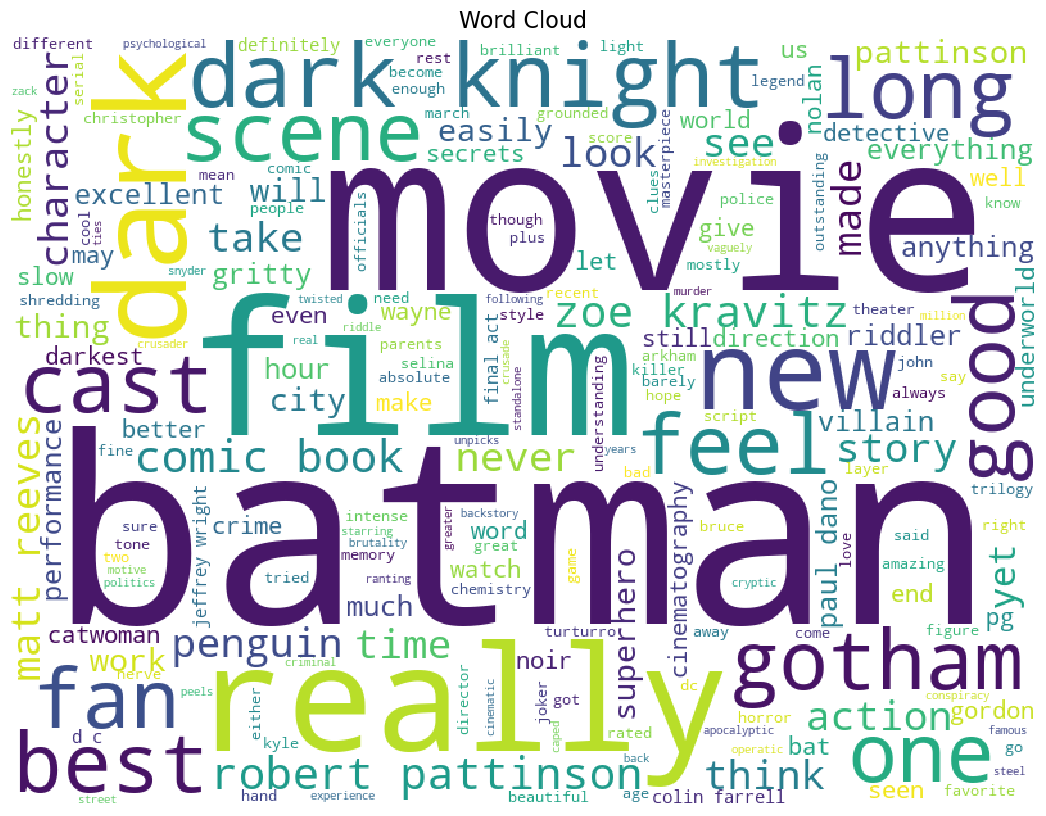

In [8]:
# Join all sentences in the 'sentences' column into a single string
text = " ".join(df['sentences'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=600, background_color="white").generate(text)

# Plot the word cloud
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation='nearest')
plt.axis("off")
plt.title("Word Cloud", fontsize=16)
plt.show()

### Entity and Relation extraction using spacy

In [9]:
# Function to extract entities from text
def extract_entities(text):
    return [(ent.text, ent.label_) for ent in nlp_spacy(text).ents]

def visualize_complex_relations(doc):
    relations = extract_relations(doc)
    visualize_relations(relations)

def visualize_relations(relations):
    G = nx.Graph()
    
    # Add entities as nodes
    for ent1, ent2 in relations:
        G.add_edge(ent1, ent2)
    
    # Draw the graph
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=12, font_weight='bold', edge_color='gray')
    plt.title("Entity Relations", fontsize=16)
    plt.show()

# Function to extract relations between entities in a document
def extract_relations(doc):
    relations = set()  # Use a set to avoid duplicates
    
    # Create a mapping of each entity to its tokens
    entity_tokens = {ent: [token for token in ent] for ent in doc.ents}

    for ent1 in doc.ents:
        head1 = ent1.root.head  # Syntactic head of the first entity

        for ent2 in doc.ents:
            # Skip identical entities and already captured reverse relations
            if ent1 == ent2 or (ent2.text, ent1.text) in relations:
                continue

            head2 = ent2.root.head  # Syntactic head of the second entity
            
            # Check for relation based on head similarity or proximity
            if head1 == head2 or ent2.root in head1.children or ent1.root in head2.children:
                relations.add((ent1.text, ent2.text))
            elif head1 in entity_tokens[ent2] or head2 in entity_tokens[ent1]:
                relations.add((ent1.text, ent2.text))
            else:
                # Calculate the proximity between entities
                min_distance = min(abs(tok1.i - tok2.i) for tok1 in entity_tokens[ent1] for tok2 in entity_tokens[ent2])
                if min_distance <= 5:
                    relations.add((ent1.text, ent2.text))

    return list(relations)  # Convert set to list for easier output handling

# Function to develop knowledge graph from a DataFrame
def develop_knowledge_graph_spacy(sp_df):
    indexes = []
    text_entities = []
    entity_types = []
    relationships = []

    for idx, row in sp_df.iterrows():
        index = idx  # Use the default index of the DataFrame
        text = row['Review']
        entities = row['spacy_entities']  # Assumed column with extracted entities
        relations = row['spacy_relations']  # Assumed column with extracted relations

        # Add entities and relationships to the lists
        for ent in entities:
            indexes.append(index)
            text_entities.append(text)
            entity_types.append(ent[0])  # Entity text
            relationships.append(ent[1])  # Entity label

        # Extract relationships between entities
        for rel in relations:
            indexes.append(index)
            text_entities.append(text)
            entity_types.append(rel[0])  # First entity
            relationships.append("related_to")  # For simplicity, use "related_to"

            indexes.append(index)
            text_entities.append(text)
            entity_types.append(rel[1])  # Second entity
            relationships.append("related_to")  # Use same relation type

    relationship_df = pd.DataFrame({
        'Index': indexes,
        'Text': text_entities,
        'Entities': entity_types,
        'Relationship': relationships
    })

    # Build the knowledge graph (directed graph)
    graph = nx.DiGraph()

    # Add entities and relationships to the graph
    for _, row in relationship_df.iterrows():
        index = row['Index']
        text = row['Text']
        entity = row['Entities']
        relationship = row['Relationship']
        graph.add_edge(index, entity, relationship=relationship, desc=text)

    # Perform connected component analysis
    connected_components = list(nx.connected_components(graph.to_undirected()))

    # Find the connected components with more than one node
    connected_components = [component for component in connected_components if len(component) > 1]

    # Display the connected components
    print("Connected components:")
    for idx, component in enumerate(connected_components, start=1):
        print(f"Component {idx}: {component}")

    # Visualize the graph (optional)
    pos = nx.spring_layout(graph, k=0.15, iterations=20)  # Layout for graph
    plt.figure(figsize=(12, 12))
    nx.draw(graph, pos, with_labels=True, node_size=5000, font_size=8, font_weight="bold", edge_color='blue')
    plt.title("Knowledge Graph Spacy - Movie Reviews", fontsize=16)
    plt.show()

# Function to develop knowledge graph from a DataFrame
def develop_knowledge_graph_spacy_llm(sp_df):
    indexes = []
    text_entities = []
    entity_types = []
    relationships = []

    for idx, row in sp_df.iterrows():
        index = idx  # Use the default index of the DataFrame
        text = row['Review']
        entities = row['transformer_entities']  # Assumed column with extracted entities
        relations = row['transformer_relations']  # Assumed column with extracted relations

        # Add entities and relationships to the lists
        for ent in entities:
            indexes.append(index)
            text_entities.append(text)
            entity_types.append(ent[0])  # Entity text
            relationships.append(ent[1])  # Entity label

        # Extract relationships between entities
        for rel in relations:
            indexes.append(index)
            text_entities.append(text)
            entity_types.append(rel[0])  # First entity
            relationships.append("related_to")  # For simplicity, use "related_to"

            indexes.append(index)
            text_entities.append(text)
            entity_types.append(rel[1])  # Second entity
            relationships.append("related_to")  # Use same relation type

    relationship_df = pd.DataFrame({
        'Index': indexes,
        'Text': text_entities,
        'Entities': entity_types,
        'Relationship': relationships
    })

    # Build the knowledge graph (directed graph)
    graph = nx.DiGraph()

    # Add entities and relationships to the graph
    for _, row in relationship_df.iterrows():
        index = row['Index']
        text = row['Text']
        entity = row['Entities']
        relationship = row['Relationship']
        graph.add_edge(index, entity, relationship=relationship, desc=text)

    # Perform connected component analysis
    connected_components = list(nx.connected_components(graph.to_undirected()))

    # Find the connected components with more than one node
    connected_components = [component for component in connected_components if len(component) > 1]

    # Display the connected components
    print("Connected components:")
    for idx, component in enumerate(connected_components, start=1):
        print(f"Component {idx}: {component}")

    # Visualize the graph (optional)
    pos = nx.spring_layout(graph, k=0.15, iterations=20)  # Layout for graph
    plt.figure(figsize=(12, 12))
    nx.draw(graph, pos, with_labels=True, node_size=5000, font_size=8, font_weight="bold", edge_color='blue')
    plt.title("Knowledge Graph Spacy + Transformer- Movie Reviews", fontsize=16)
    plt.show()

In [10]:
df['spacy_entities'] = df['sentences'].apply(extract_entities)
df['spacy_relations'] = df['sentences'].apply(lambda x: extract_relations(nlp_spacy(x)))

### Let's do visualiation

In [11]:
df.spacy_entities[0]

[('batman', 'WORK_OF_ART'),
 ('robert pattinson', 'PERSON'),
 ('dc', 'PERSON'),
 ('2022', 'DATE'),
 ('the batman', 'WORK_OF_ART'),
 ('bruce waynes', 'PERSON'),
 ('wayne', 'PERSON'),
 ('two years', 'DATE'),
 ('gotham city', 'GPE'),
 ('batman', 'PERSON'),
 ('batman', 'PERSON'),
 ('march 4', 'DATE'),
 ('christopher nolan', 'PERSON'),
 ('zack snyder', 'PERSON'),
 ('joker', 'PERSON'),
 ('batman', 'WORK_OF_ART'),
 ('13', 'CARDINAL'),
 ('dark knight', 'WORK_OF_ART'),
 ('marvel', 'PERSON'),
 ('three hours', 'TIME'),
 ('robert pattinson', 'PERSON'),
 ('batman', 'PERSON'),
 ('christian bales', 'PERSON'),
 ('one', 'CARDINAL'),
 ('matt reeves', 'PERSON'),
 ('christopher nolan', 'PERSON'),
 ('batman', 'WORK_OF_ART'),
 ('13', 'CARDINAL'),
 ('michael giacchino', 'PERSON'),
 ('batman', 'PERSON'),
 ('selina', 'PERSON'),
 ('nirvana', 'ORG'),
 ('batman', 'WORK_OF_ART'),
 ('march 4 2022', 'DATE')]

In [12]:
# Visualize Named Entities for the first sentence
spacy.displacy.render(nlp_spacy(df['sentences'][0]), style="ent", jupyter=True, 
                      options={'distance': 100, 'color': 'orange', 'font': 'Source Sans Pro'})

In [13]:
# Visualize Dependency Parsing for the first sentence
spacy.displacy.render(nlp_spacy(df['sentences'][0]), style="dep", jupyter=True, 
                      options={'distance': 100, 'color': 'blue', 'font': 'Source Sans Pro'})

In [14]:
# Visualize Named Entities for the first 3 sentences
for sentence in df['sentences'][:3]:
    spacy.displacy.render(nlp_spacy(sentence), style="ent", jupyter=True, 
                          options={'distance': 100, 'color': 'orange', 'font': 'Source Sans Pro'})
    print("\n")

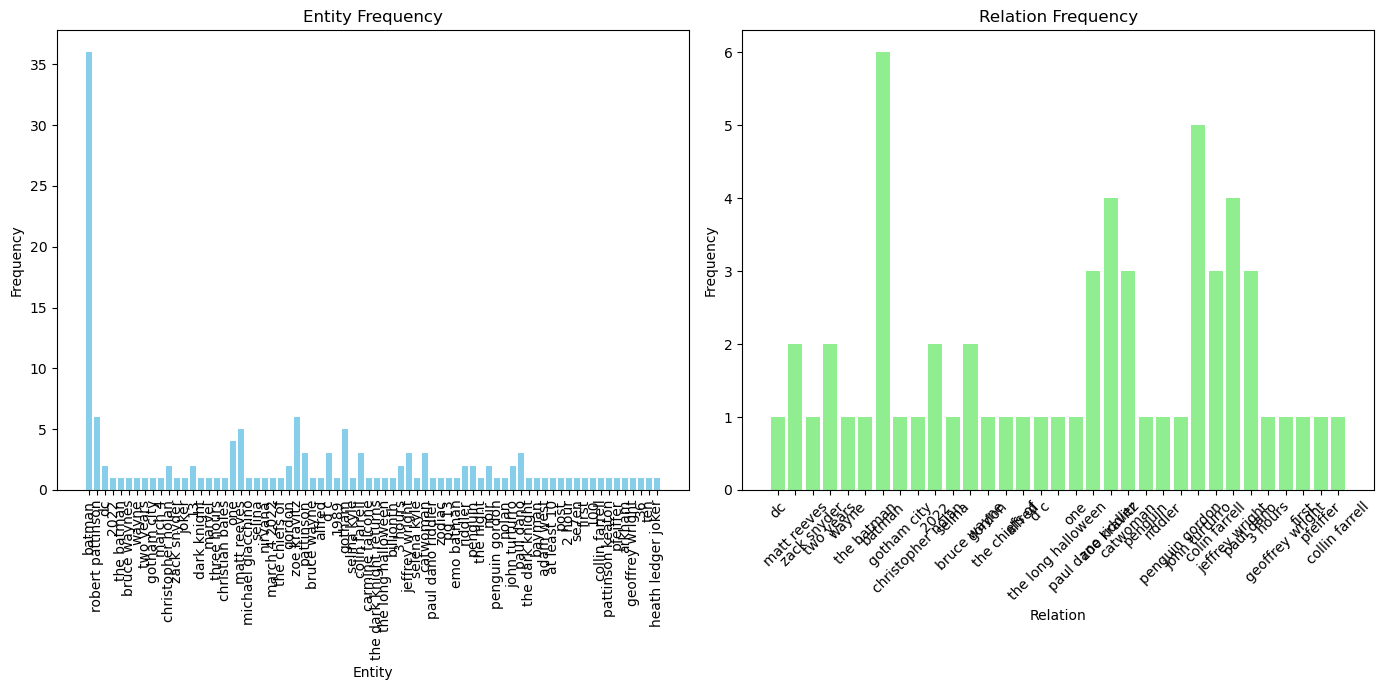

In [15]:
# Count the frequency of each entity
entity_counter = Counter([ent for sentence in df['spacy_entities'] for ent, label in sentence])

# Count the frequency of each relation
relation_counter = Counter([rel[1] for sentence in df['spacy_relations'] for rel in sentence])

# Plot bar charts for entity and relation frequencies
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Entity frequency plot
axes[0].bar(entity_counter.keys(), entity_counter.values(), color='skyblue')
axes[0].set_title("Entity Frequency")
axes[0].set_xlabel("Entity")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', rotation=90)

# Relation frequency plot
axes[1].bar(relation_counter.keys(), relation_counter.values(), color='lightgreen')
axes[1].set_title("Relation Frequency")
axes[1].set_xlabel("Relation")
axes[1].set_ylabel("Frequency")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [16]:
df.spacy_relations[0]

[('robert pattinson', 'dc'),
 ('one', 'matt reeves'),
 ('christopher nolan', 'zack snyder'),
 ('bruce waynes', 'two years'),
 ('bruce waynes', 'wayne'),
 ('2022', 'the batman'),
 ('wayne', 'two years'),
 ('gotham city', 'batman'),
 ('two years', 'gotham city'),
 ('matt reeves', 'christopher nolan'),
 ('robert pattinson', 'batman'),
 ('robert pattinson', '2022'),
 ('dc', '2022'),
 ('batman', 'selina')]

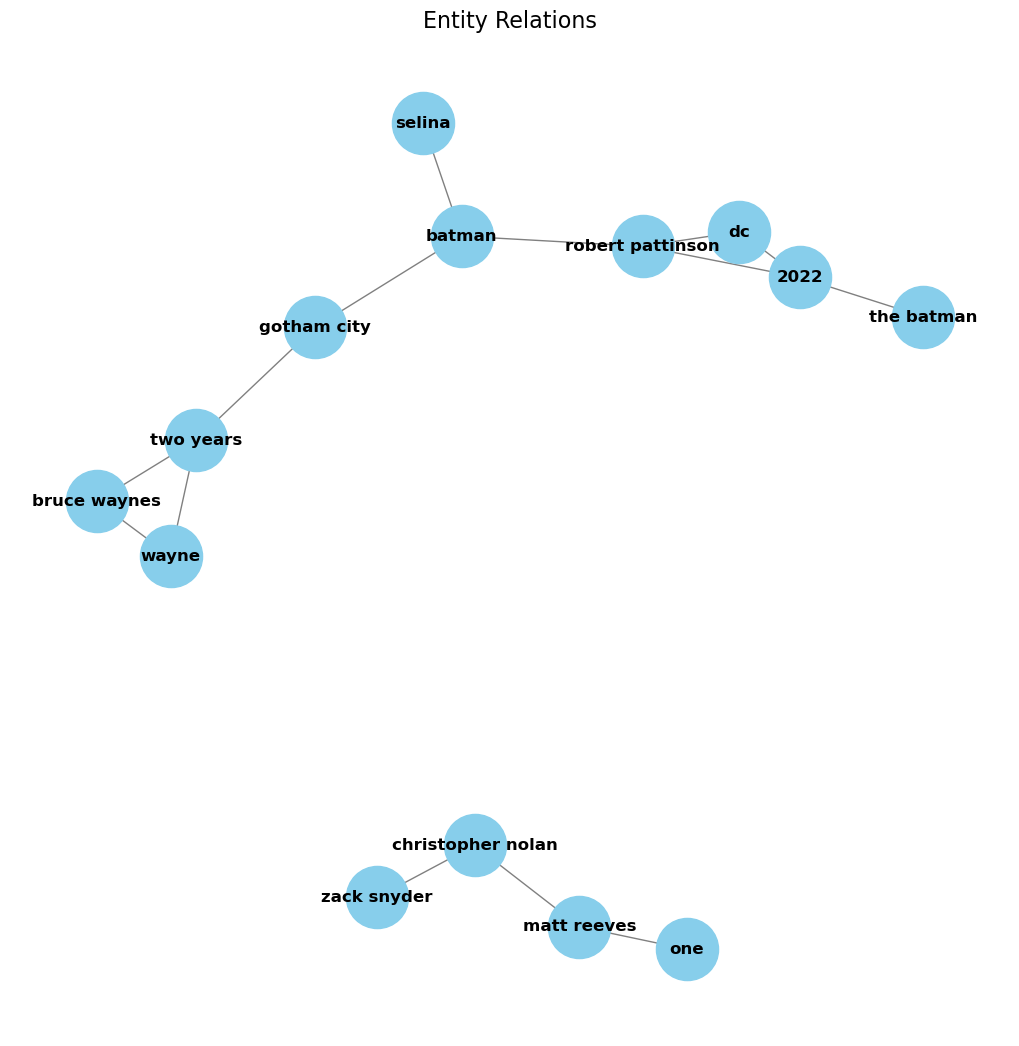

In [17]:
# Example of visualizing relations and entities sentence
doc = nlp_spacy(df['sentences'][0])
visualize_complex_relations(doc)

### Automatic knowledge graph generation

Connected components:
Component 1: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'catwoman', 'selina', '13', 'pg 13', 'paul dano', '2022', 'selina kyle', 'colin farrell', 'at least 10', 'd c', 'bruce waynes', 'christian bales', 'noir', '2 hour', 'gordon', 'penguin gordon', 'joker', 'two years', '36', 'batman', 'christopher nolan', 'billionth', 'bayman', 'jeffrey wright', 'zodiac', '100', 'the chiefs of', 'march 4 2022', 'michael giacchino', 'john turturro', 'dc', 'one', 'gotham city', 'riddler', 'gotham', 'selena kyle', 'wayne', 'paul dano riddler', 'the dark knight', 'zoe kravitz', 'pattinson', 'nolan', '3 hours', 'the long halloween', 'the dark knight returns', 'robert pattinson', 'se7en', 'the batman', 'dark knight', 'pfeiffer', 'arkham', 'heath ledger joker', 'the night', 'emo batman', 'post', 'marvel', 'march 4', 'penguin', 'adam west', 'matt reeves', 'zack snyder', 'pattinson keaton', 'geoffrey wright', 'three hours', 'collin farrell', 'alfred', 'ten', 'bruce wayne', 'carmine falcone', 'first',

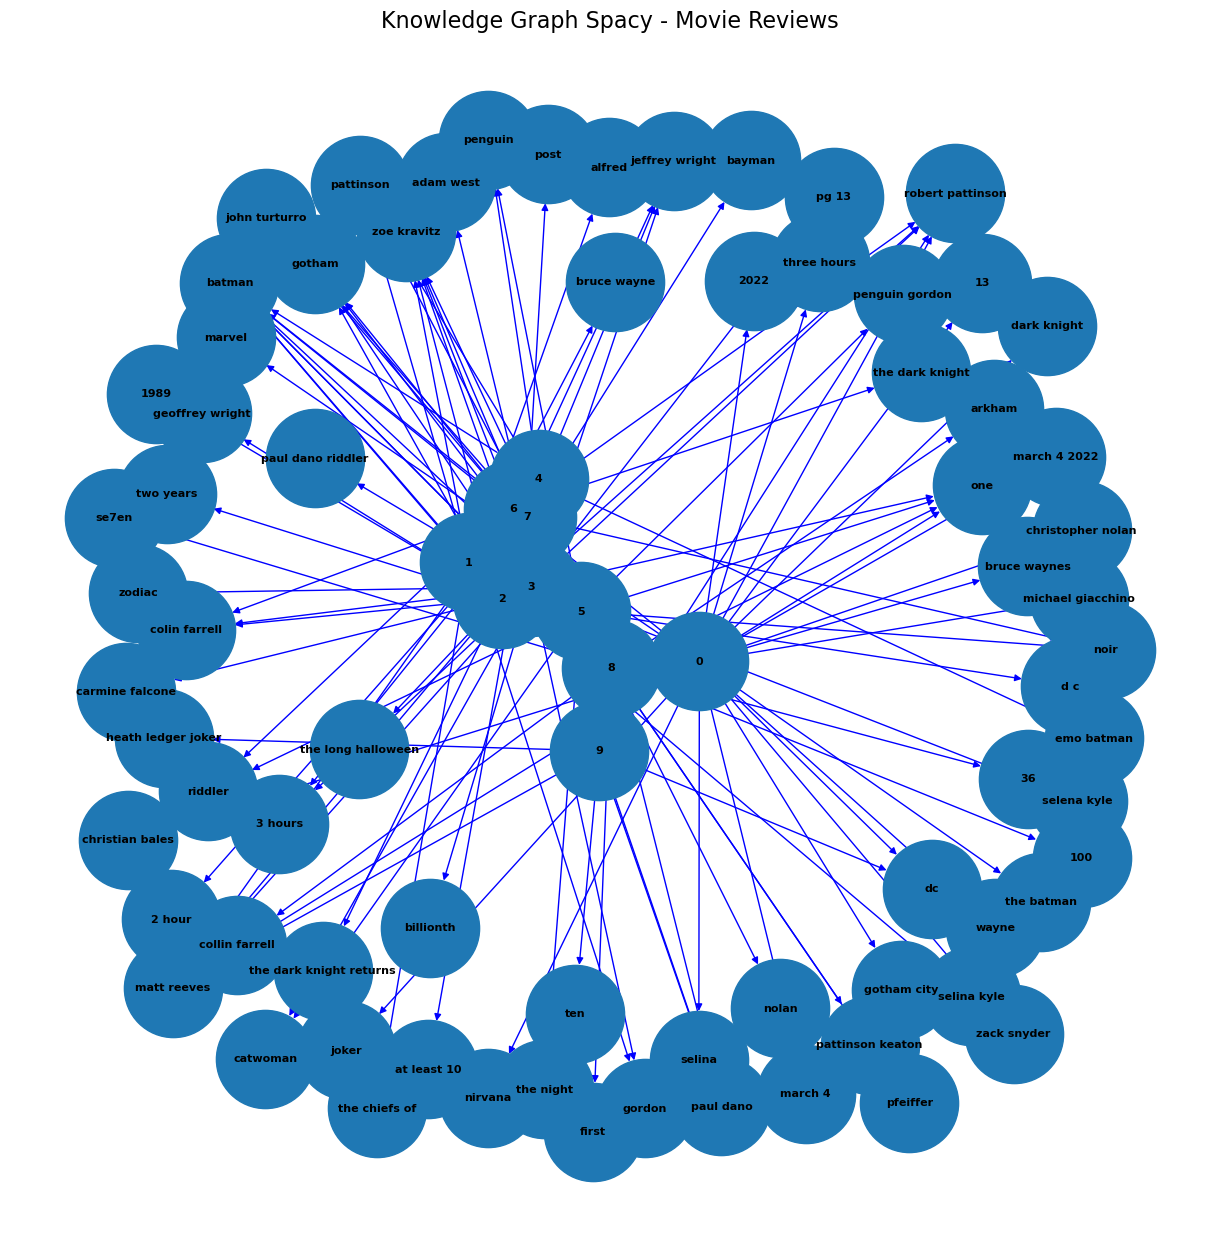

In [18]:
# Run the knowledge graph development function on the dataframe
develop_knowledge_graph_spacy(df)

### Entity and Relation extraction using LLM+spacy

In [19]:
# Function to extract entities using both transformers (BERT) and SpaCy
def extract_entities_transformers_spacy(sentence):
    # Extract entities using Hugging Face transformer model
    ner_results = nlp_ner(sentence)
    transformer_entities = [(result['word'], result['entity']) for result in ner_results]

    # Extract entities using SpaCy
    spacy_doc = nlp_spacy(sentence)
    spacy_entities = [(ent.text, ent.label_) for ent in spacy_doc.ents]

    # Combine the results
    # You can choose to merge or choose based on certain conditions (e.g., priority)
    all_entities = transformer_entities + spacy_entities

    # Optionally, you can remove duplicates by converting to a set and back to a list if needed
    all_entities = list(set(all_entities))  # Remove duplicates

    return all_entities

In [20]:
# Apply the function to the DataFrame and create a new column
df['transformer_entities'] = df['sentences'].apply(extract_entities_transformers_spacy)

In [21]:
def extract_relations_spacy(doc):
    relations = []
    visited = set()

    # Collect all entities in the document
    entity_spans = [ent for ent in doc.ents]

    # Iterate over all unique pairs of entities
    for i, ent1 in enumerate(entity_spans):
        for ent2 in entity_spans[i+1:]:  # Only consider each pair once
            if (ent1, ent2) in visited or (ent2, ent1) in visited:
                continue  # Skip if the pair has already been processed
            visited.add((ent1, ent2))

            # Check if entities share the same syntactic head
            if ent1.root.head == ent2.root.head:
                relations.append((ent1.text, ent1.root.head.lemma_, ent2.text, ent1.label_, ent2.label_))
            # Check if one entity's head is connected to the other entity's root
            elif ent1.root.head == ent2.root or ent1.root == ent2.root.head:
                relations.append((ent1.text, ent1.root.head.lemma_ + ' ' + ent2.root.head.lemma_, ent2.text, ent1.label_, ent2.label_))
            # Check if entities are in each other's subtree
            elif ent2 in ent1.subtree or ent1 in ent2.subtree:
                relations.append((ent1.text, "related_to", ent2.text, ent1.label_, ent2.label_))
            else:
                # Check for relationships based on prepositions or direct object relations
                for token in doc:
                    if token.dep_ in ("prep", "agent", "pobj", "dobj"):
                        # Check if the token is related to the root of either entity
                        if token.head == ent1.root and token.head == ent2.root:
                            relations.append((ent1.text, token.lemma_, ent2.text, ent1.label_, ent2.label_))
                        elif token.head == ent2.root and token.head == ent1.root:
                            relations.append((ent1.text, token.lemma_, ent2.text, ent1.label_, ent2.label_))
                        elif token.head == ent1.root or token.head == ent2.root:
                            if token.head.head == ent1.root or token.head.head == ent2.root:
                                relations.append((ent1.text, token.lemma_, ent2.text, ent1.label_, ent2.label_))

    return relations

# Apply the relation extraction function to each sentence
def extract_relations_from_entities(row):
    # Get the sentence from the row
    sentence = row['sentences']
    
    # Process the sentence with SpaCy to get the document object
    doc = nlp_spacy(sentence)
    
    # Extract relations using the 'extract_relations_spacy' function
    relations = extract_relations_spacy(doc)
    
    return relations

In [22]:
df['transformer_relations'] = df.apply(extract_relations_from_entities, axis=1)

### Word Cloud to check the most occuring words

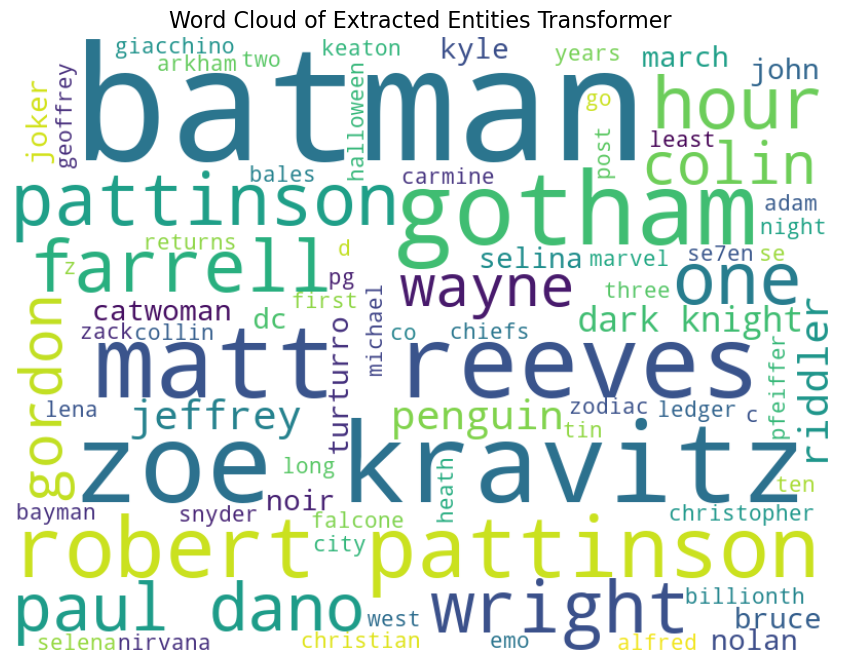

In [23]:
# Flatten the list of entities
entities = [ent for sentence in df['transformer_entities'] for ent, label in sentence]  # Assuming 'spacy_entities' contains the entities

# Create a word cloud from the entities
wordcloud = WordCloud(width=800, height=600, background_color="white").generate(' '.join(entities))

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Extracted Entities Transformer", fontsize=16)
plt.show()

### Let's do visualiation

In [24]:
df.transformer_entities[0]

[('bruce waynes', 'PERSON'),
 ('matt reeves', 'PERSON'),
 ('dark knight', 'WORK_OF_ART'),
 ('three hours', 'TIME'),
 ('marvel', 'PERSON'),
 ('two years', 'DATE'),
 ('christian bales', 'PERSON'),
 ('joker', 'PERSON'),
 ('13', 'CARDINAL'),
 ('the batman', 'WORK_OF_ART'),
 ('dc', 'PERSON'),
 ('batman', 'PERSON'),
 ('wayne', 'PERSON'),
 ('2022', 'DATE'),
 ('selina', 'PERSON'),
 ('michael giacchino', 'PERSON'),
 ('christopher nolan', 'PERSON'),
 ('gotham city', 'GPE'),
 ('march 4 2022', 'DATE'),
 ('batman', 'WORK_OF_ART'),
 ('march 4', 'DATE'),
 ('robert pattinson', 'PERSON'),
 ('one', 'CARDINAL'),
 ('nirvana', 'ORG'),
 ('zack snyder', 'PERSON')]

In [25]:
# Visualize Named Entities for the first sentence
spacy.displacy.render(nlp_spacy(df['sentences'][0]), style="ent", jupyter=True, 
                      options={'distance': 100, 'color': 'orange', 'font': 'Source Sans Pro'})

In [26]:
# Visualize Dependency Parsing for the first sentence
spacy.displacy.render(nlp_spacy(df['sentences'][3]), style="dep", jupyter=True, 
                      options={'distance': 100, 'color': 'blue', 'font': 'Source Sans Pro'})

In [27]:
# Visualize Named Entities for the next 3 sentences
for sentence in df['sentences'][3:6]:
    spacy.displacy.render(nlp_spacy(sentence), style="ent", jupyter=True, 
                          options={'distance': 100, 'color': 'orange', 'font': 'Source Sans Pro'})
    print("\n")

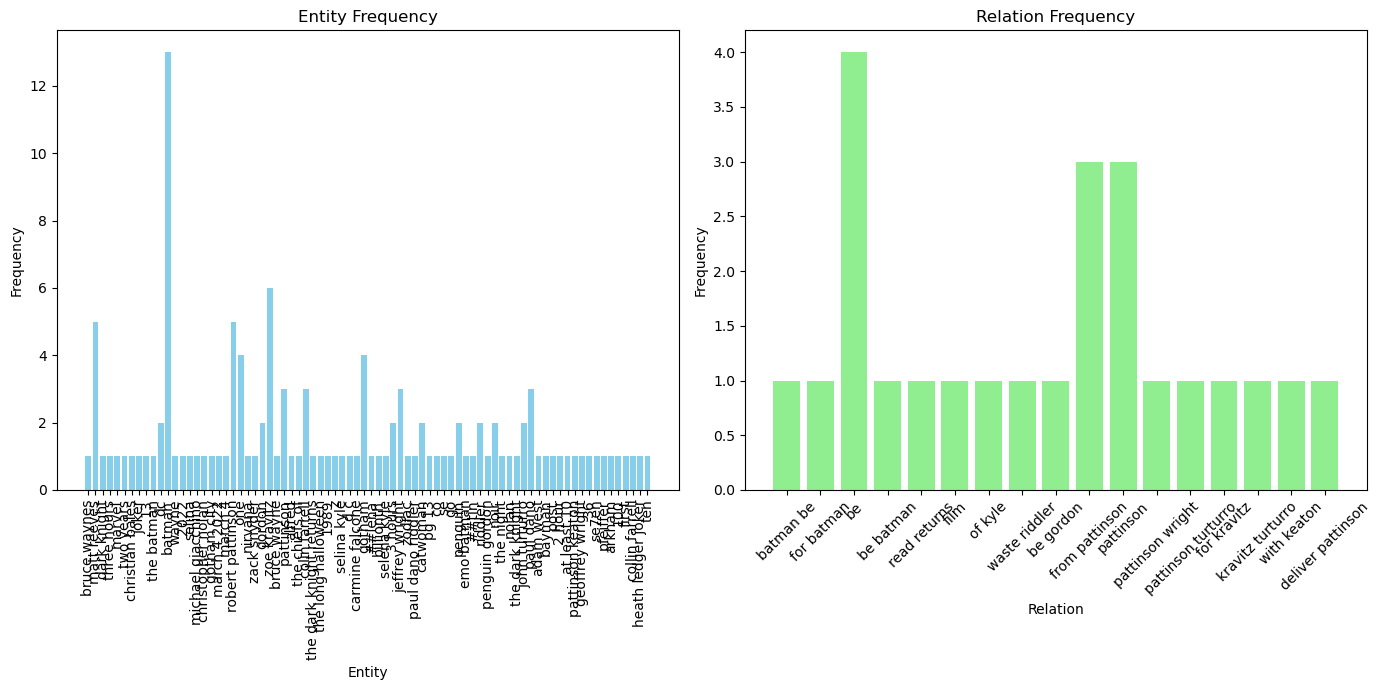

In [28]:
# Count the frequency of each entity
entity_counter = Counter([ent for sentence in df['transformer_entities'] for ent, label in sentence])

# Count the frequency of each relation
relation_counter = Counter([rel[1] for sentence in df['transformer_relations'] for rel in sentence])

# Plot bar charts for entity and relation frequencies
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Entity frequency plot
axes[0].bar(entity_counter.keys(), entity_counter.values(), color='skyblue')
axes[0].set_title("Entity Frequency")
axes[0].set_xlabel("Entity")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', rotation=90)

# Relation frequency plot
axes[1].bar(relation_counter.keys(), relation_counter.values(), color='lightgreen')
axes[1].set_title("Relation Frequency")
axes[1].set_xlabel("Relation")
axes[1].set_ylabel("Frequency")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [29]:
df.transformer_relations[0]

[('robert pattinson', 'batman be', 'batman', 'PERSON', 'PERSON'),
 ('batman', 'for batman', 'selina', 'PERSON', 'PERSON')]

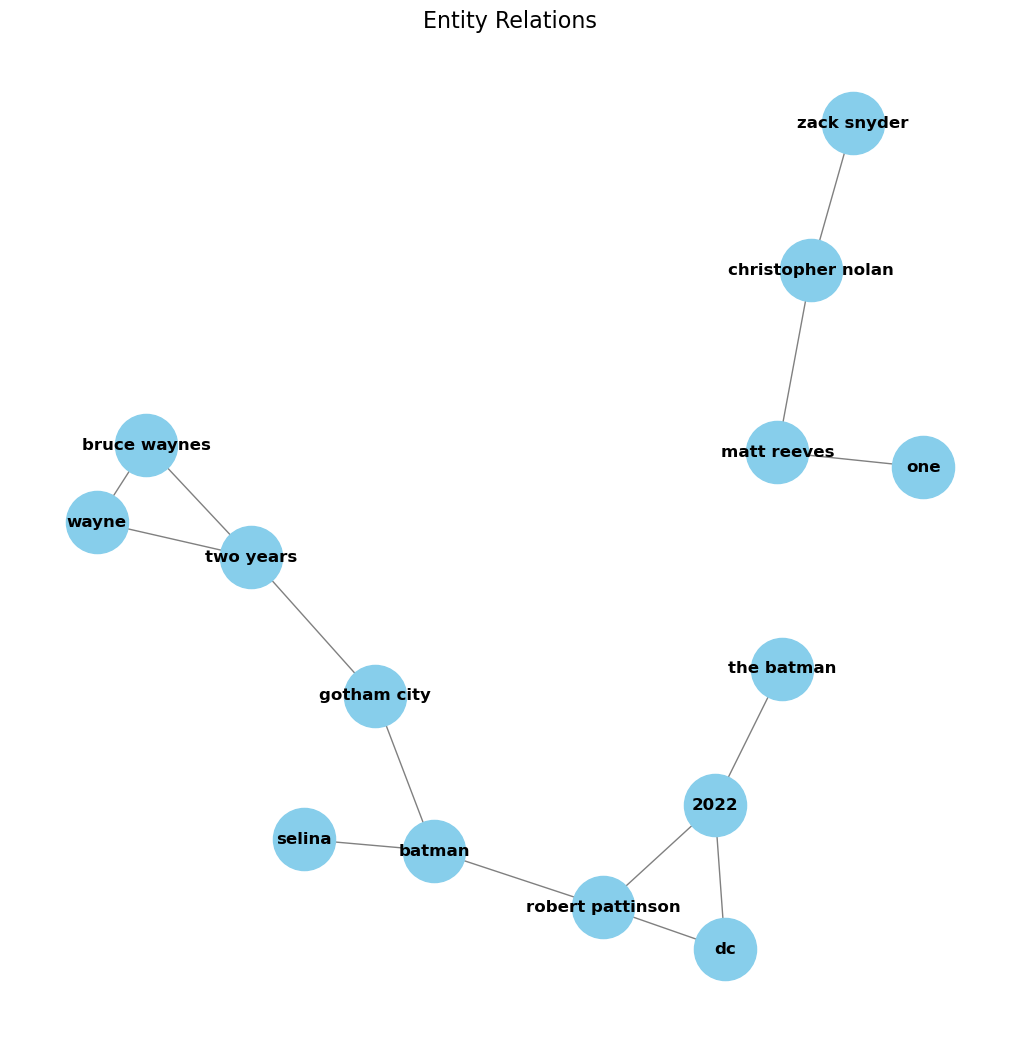

In [30]:
# Example of visualizing relations and entities sentence
doc = nlp_spacy(df['sentences'][0])
visualize_complex_relations(doc)

### Automatic knowledge graph generation

Connected components:
Component 1: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'catwoman', 'se', 'selina', 'co', '13', 'pg 13', 'paul dano', 'be gordon', '2022', 'selina kyle', 'pattinson wright', 'from pattinson', 'colin farrell', 'at least 10', 'd c', 'bruce waynes', 'christian bales', 'noir', '2 hour', 'gordon', 'be', 'penguin gordon', 'joker', 'film', 'two years', 'with keaton', '36', 'batman', 'christopher nolan', 'billionth', 'bayman', 'jeffrey wright', '##lena', '##tin', 'zodiac', 'kravitz turturro', '100', 'the chiefs of', 'read returns', 'march 4 2022', 'michael giacchino', 'john turturro', 'batman be', 'dc', 'one', 'gotham city', 'waste riddler', 'for batman', 'riddler', 'gotham', 'selena kyle', 'wayne', 'go', 'be batman', 'paul dano riddler', 'the dark knight', 'zoe kravitz', 'pattinson', 'nolan', '3 hours', 'the long halloween', 'the dark knight returns', 'of kyle', 'robert pattinson', 'se7en', 'the batman', 'dark knight', 'z', 'deliver pattinson', 'pfeiffer', 'arkham', 'heath ledger jo

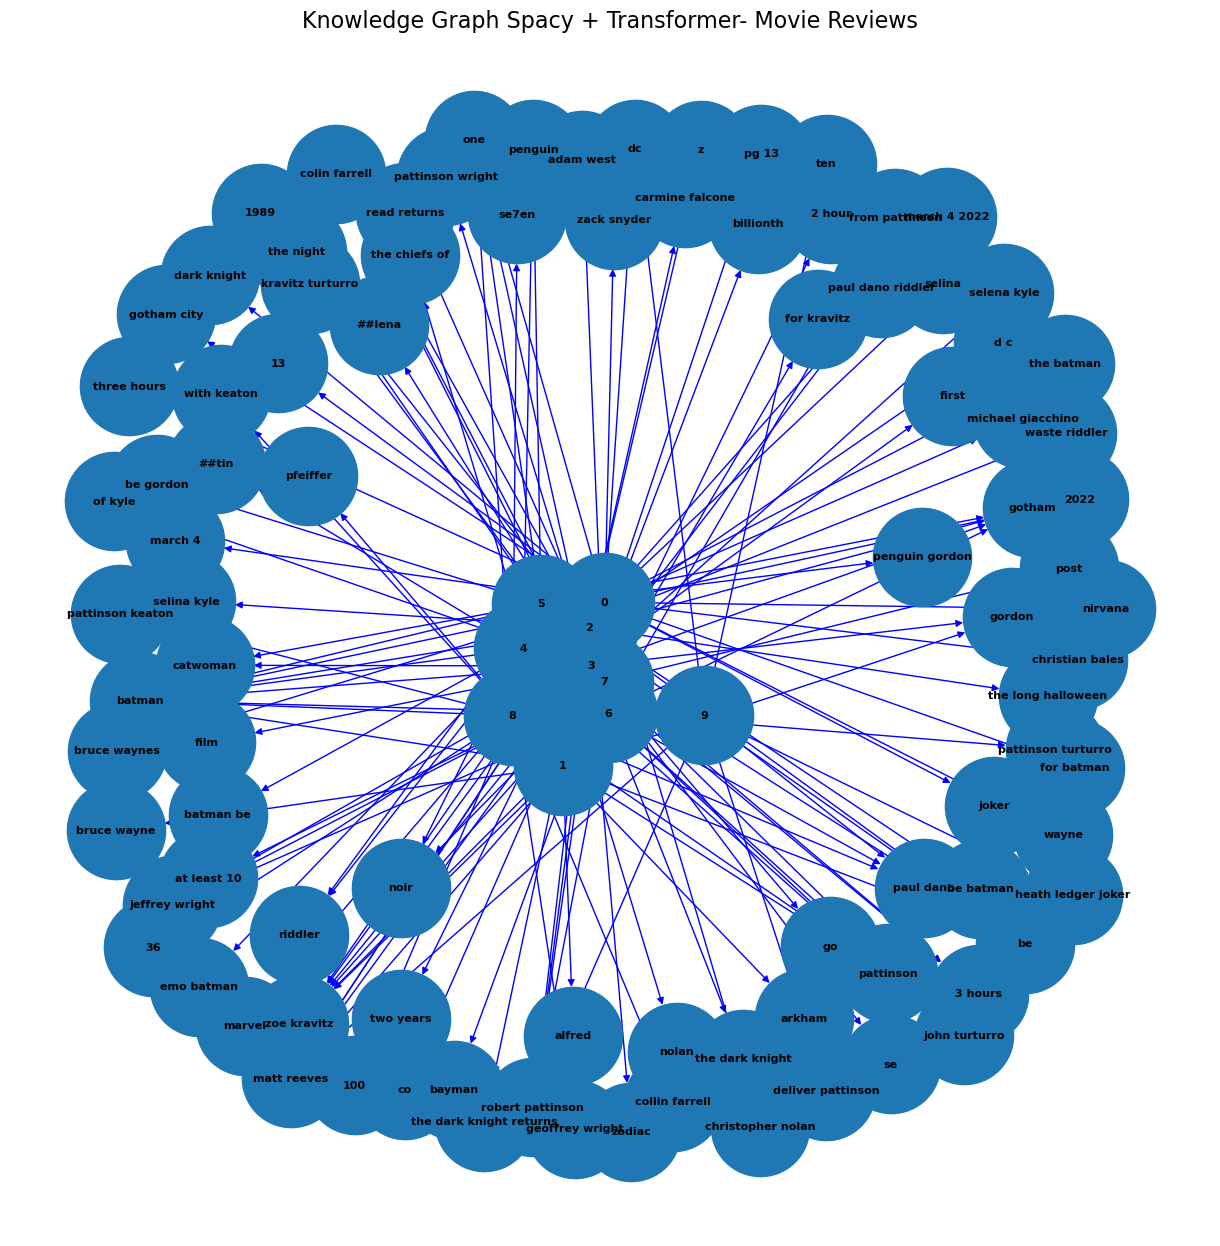

In [31]:
# Run the knowledge graph development function on the dataframe
develop_knowledge_graph_spacy_llm(df)

### Evaluate the performance for both entity and relation extraction tasks

In [32]:
df.head(10)

,Review,sentences,spacy_entities,spacy_relations,transformer_entities,transformer_relations
0,"You've seen a million Batman movies, but you s...",you have seen a million batman movies but you ...,"[(batman, WORK_OF_ART), (robert pattinson, PER...","[(robert pattinson, dc), (one, matt reeves), (...","[(bruce waynes, PERSON), (matt reeves, PERSON)...","[(robert pattinson, batman be, batman, PERSON,..."
1,Some cool action scenes but doesn't deliver on...,some cool action scenes but does not deliver o...,"[(batman, PERSON), (batman, PERSON), (the chie...","[(pattinson, bruce wayne), (pattinson, batman)...","[(gordon, PERSON), (zoe kravitz, PERSON), (bru...","[(pattinson, be, bruce wayne, PERSON, PERSON)]"
2,"Always been a ""Batman"" fan as the D. C. legend...",always been a batman fan as the d c legend is ...,"[(batman, PERSON), (d c, ORG), (1989, DATE), (...","[(batman, matt reeves), (batman, d c), (batman...","[(colin farrell, PERSON), (the dark knight ret...","[(batman, be, batman, WORK_OF_ART, WORK_OF_ART..."
3,"Yes, it may be the billionth Batman film in re...",yes it may be the billionth batman film in rec...,"[(billionth, ORDINAL), (batman, PERSON), (batm...","[(batman, one), (jeffrey wright, paul dano rid...","[(##lena, B-PER), (matt reeves, PERSON), (bill...","[(billionth, film, batman, ORDINAL, PERSON), (..."
4,I really don't understand all the love for thi...,i really do not understand all the love for th...,"[(batman, PERSON), (emo batman, PERSON), (patt...","[(riddler, penguin)]","[(penguin, PERSON), (emo batman, PERSON), (##t...","[(riddler, waste riddler, penguin, PERSON, PER..."
5,I'm a huge Batman fan. The reviews and the sco...,i am a huge batman fan the reviews and the sco...,"[(batman, PERSON), (the night, TIME), (noir, N...","[(batman, riddler), (penguin, penguin gordon),...","[(penguin, PERSON), (penguin gordon, PERSON), ...","[(penguin, be, penguin gordon, PERSON, PERSON)..."
6,The Batman is a absolute amazing film from dir...,the batman is a absolute amazing film from dir...,"[(batman, WORK_OF_ART), (matt reeves, PERSON),...","[(jeffrey wright, john turturro), (robert patt...","[(jeffrey wright, PERSON), (the dark knight, P...","[(robert pattinson, from pattinson, zoe kravit..."
7,"Wow! There is so much to dislike about ""The Ba...",wow there is so much to dislike about the baym...,"[(bayman, PERSON), (noir, PERSON), (3 hours, T...","[(noir, 3 hours), (2 hour, zoe kravitz), (zoe ...","[(noir, PERSON), (jeffrey wright, PERSON), (ad...","[(zoe kravitz, for kravitz, john turturro, PER..."
8,I just got out of The Batman\n\nThis movie rea...,i just got out of the batman this movie really...,"[(batman, WORK_OF_ART), (batman, PERSON), (se7...","[(arkham, geoffrey wright), (se7en, batman), (...","[(pattinson keaton, PERSON), (geoffrey wright,...","[(pattinson keaton, with keaton, pfeiffer, PER..."
9,"Can't say much since this is spoiler free, but...",cannot say much since this is spoiler free but...,"[(ten, CARDINAL), (dc, ORG), (matt reeves, PER...","[(robert pattinson, paul dano)]","[(dc, ORG), (matt reeves, PERSON), (heath ledg...","[(robert pattinson, deliver pattinson, paul da..."


In [33]:
print("Sentence: ", df['sentences'][1])
print("\nSpacy Entities: ", df['spacy_entities'][1])
print("\nTransformer Entities: ", df['transformer_entities'][1])
print("\nSpacy Relation: ", df['spacy_relations'][1])
print("\nTransformer Relation: ", df['transformer_relations'][1])

Sentence:  some cool action scenes but does not deliver on the detective side of batman the dialogue was also really bad most people either yelled or tried talking in these silly deep voices and in this case it was not batman it was the chiefs of police and gordon they just did not work zoe kravitz was good as cat woman pattinson was actually good as batman but not a good bruce wayne alfred was pointless the script over all just was not that good the cinematography could have been better too they tried to be different with their realistic camera angles but mostly they failed it missed the marked and lastly it was too long and too slow

Spacy Entities:  [('batman', 'PERSON'), ('batman', 'PERSON'), ('the chiefs of', 'PERSON'), ('gordon', 'PERSON'), ('zoe kravitz', 'PERSON'), ('pattinson', 'PERSON'), ('batman', 'PERSON'), ('bruce wayne', 'PERSON'), ('alfred', 'PERSON')]

Transformer Entities:  [('gordon', 'PERSON'), ('zoe kravitz', 'PERSON'), ('bruce wayne', 'PERSON'), ('batman', 'PERSON'

Lets clean the entities and format them correctly and remove duplicates

In [34]:
def clean_and_deduplicate(entities, relations=None, entity_type_map=None):
    """
    Cleans and removes duplicates from entities and relations.
    
    Args:
    - entities: A list of tuples representing entities (word, entity_type, start, end)
    - relations: Optional; A list of relations (entity1, relationship, entity2)
    - entity_type_map: Optional; A dictionary to map entity types (e.g., Transformer entity types to SpaCy ones)

    Returns:
    - cleaned_entities: A list of cleaned entities.
    - cleaned_relations: A list of cleaned relations.
    """
    cleaned_entities = []
    seen_entities = set()
    seen_relations = set()

    # Filter out any None values and duplicate entities
    for entity in entities:
        if len(entity) == 4:
            word, entity_type, start, end = entity
        else:
            word, entity_type = entity
            start, end = None, None

        # Skip if None values for word or entity_type
        if word is None or entity_type is None:
            continue
        
        # Remove sub-token markers and merge tokens
        if word.startswith("##"):
            word = word[2:]  # Merge sub-tokens
        if (word, entity_type) not in seen_entities:
            cleaned_entities.append((word, entity_type, start, end))
            seen_entities.add((word, entity_type))

    # Optional: Map entity types if a mapping is provided (for transformer vs spaCy)
    if entity_type_map:
        cleaned_entities = [(word, entity_type_map.get(entity_type, entity_type), start, end) 
                            for word, entity_type, start, end in cleaned_entities]

    # Clean relations if provided and remove duplicates
    cleaned_relations = []
    if relations:
        for relation in relations:
            # Normalize transformer relations to the simpler form
            if len(relation) == 5:
                entity1, relationship, entity2, label1, label2 = relation
                relation = (entity1, entity2)  # Strip out the label for simplicity
            if relation not in seen_relations:
                cleaned_relations.append(relation)
                seen_relations.add(relation)

    return cleaned_entities, cleaned_relations



In [35]:
# Define a simple entity type mapping, if necessary
entity_type_map = {
    "I-PER": "PERSON",
    "I-ORG": "ORG",
    "I-LOC": "GPE",
    "I-MISC": "MISC",
    # Add more mappings if needed
}

# Clean and deduplicate SpaCy entities and relations
df['cleaned_spacy_entities'], df['cleaned_spacy_relations'] = zip(*df.apply(
    lambda row: clean_and_deduplicate(row['spacy_entities'], row['spacy_relations'], entity_type_map), axis=1
))

# Clean and deduplicate Transformer entities and relations
df['cleaned_transformer_entities'], df['cleaned_transformer_relations'] = zip(*df.apply(
    lambda row: clean_and_deduplicate(row['transformer_entities'], row['transformer_relations'], entity_type_map), axis=1
))


In [36]:
df.head(10)

,Review,sentences,spacy_entities,spacy_relations,transformer_entities,transformer_relations,cleaned_spacy_entities,cleaned_spacy_relations,cleaned_transformer_entities,cleaned_transformer_relations
0,"You've seen a million Batman movies, but you s...",you have seen a million batman movies but you ...,"[(batman, WORK_OF_ART), (robert pattinson, PER...","[(robert pattinson, dc), (one, matt reeves), (...","[(bruce waynes, PERSON), (matt reeves, PERSON)...","[(robert pattinson, batman be, batman, PERSON,...","[(batman, WORK_OF_ART, None, None), (robert pa...","[(robert pattinson, dc), (one, matt reeves), (...","[(bruce waynes, PERSON, None, None), (matt ree...","[(robert pattinson, batman), (batman, selina)]"
1,Some cool action scenes but doesn't deliver on...,some cool action scenes but does not deliver o...,"[(batman, PERSON), (batman, PERSON), (the chie...","[(pattinson, bruce wayne), (pattinson, batman)...","[(gordon, PERSON), (zoe kravitz, PERSON), (bru...","[(pattinson, be, bruce wayne, PERSON, PERSON)]","[(batman, PERSON, None, None), (the chiefs of,...","[(pattinson, bruce wayne), (pattinson, batman)...","[(gordon, PERSON, None, None), (zoe kravitz, P...","[(pattinson, bruce wayne)]"
2,"Always been a ""Batman"" fan as the D. C. legend...",always been a batman fan as the d c legend is ...,"[(batman, PERSON), (d c, ORG), (1989, DATE), (...","[(batman, matt reeves), (batman, d c), (batman...","[(colin farrell, PERSON), (the dark knight ret...","[(batman, be, batman, WORK_OF_ART, WORK_OF_ART...","[(batman, PERSON, None, None), (d c, ORG, None...","[(batman, matt reeves), (batman, d c), (batman...","[(colin farrell, PERSON, None, None), (the dar...","[(batman, batman), (batman, d c), (the dark kn..."
3,"Yes, it may be the billionth Batman film in re...",yes it may be the billionth batman film in rec...,"[(billionth, ORDINAL), (batman, PERSON), (batm...","[(batman, one), (jeffrey wright, paul dano rid...","[(##lena, B-PER), (matt reeves, PERSON), (bill...","[(billionth, film, batman, ORDINAL, PERSON), (...","[(billionth, ORDINAL, None, None), (batman, PE...","[(batman, one), (jeffrey wright, paul dano rid...","[(lena, B-PER, None, None), (matt reeves, PERS...","[(billionth, batman), (jeffrey wright, paul da..."
4,I really don't understand all the love for thi...,i really do not understand all the love for th...,"[(batman, PERSON), (emo batman, PERSON), (patt...","[(riddler, penguin)]","[(penguin, PERSON), (emo batman, PERSON), (##t...","[(riddler, waste riddler, penguin, PERSON, PER...","[(batman, PERSON, None, None), (emo batman, PE...","[(riddler, penguin)]","[(penguin, PERSON, None, None), (emo batman, P...","[(riddler, penguin)]"
5,I'm a huge Batman fan. The reviews and the sco...,i am a huge batman fan the reviews and the sco...,"[(batman, PERSON), (the night, TIME), (noir, N...","[(batman, riddler), (penguin, penguin gordon),...","[(penguin, PERSON), (penguin gordon, PERSON), ...","[(penguin, be, penguin gordon, PERSON, PERSON)...","[(batman, PERSON, None, None), (the night, TIM...","[(batman, riddler), (penguin, penguin gordon),...","[(penguin, PERSON, None, None), (penguin gordo...","[(penguin, penguin gordon), (penguin gordon, c..."
6,The Batman is a absolute amazing film from dir...,the batman is a absolute amazing film from dir...,"[(batman, WORK_OF_ART), (matt reeves, PERSON),...","[(jeffrey wright, john turturro), (robert patt...","[(jeffrey wright, PERSON), (the dark knight, P...","[(robert pattinson, from pattinson, zoe kravit...","[(batman, WORK_OF_ART, None, None), (matt reev...","[(jeffrey wright, john turturro), (robert patt...","[(jeffrey wright, PERSON, None, None), (the da...","[(robert pattinson, zoe kravitz), (robert patt..."
7,"Wow! There is so much to dislike about ""The Ba...",wow there is so much to dislike about the baym...,"[(bayman, PERSON), (noir, PERSON), (3 hours, T...","[(noir, 3 hours), (2 hour, zoe kravitz), (zoe ...","[(noir, PERSON), (jeffrey wright, PERSON), (ad...","[(zoe kravitz, for kra

In [37]:
print("Sentence: ", df['sentences'][1])
print("\nSpacy Entities: ", df['cleaned_spacy_entities'][1])
print("\nTransformer Entities: ", df['cleaned_transformer_entities'][1])
print("\nSpacy Relation: ", df['cleaned_spacy_relations'][1])
print("\nTransformer Relation: ", df['cleaned_transformer_relations'][1])

Sentence:  some cool action scenes but does not deliver on the detective side of batman the dialogue was also really bad most people either yelled or tried talking in these silly deep voices and in this case it was not batman it was the chiefs of police and gordon they just did not work zoe kravitz was good as cat woman pattinson was actually good as batman but not a good bruce wayne alfred was pointless the script over all just was not that good the cinematography could have been better too they tried to be different with their realistic camera angles but mostly they failed it missed the marked and lastly it was too long and too slow

Spacy Entities:  [('batman', 'PERSON', None, None), ('the chiefs of', 'PERSON', None, None), ('gordon', 'PERSON', None, None), ('zoe kravitz', 'PERSON', None, None), ('pattinson', 'PERSON', None, None), ('bruce wayne', 'PERSON', None, None), ('alfred', 'PERSON', None, None)]

Transformer Entities:  [('gordon', 'PERSON', None, None), ('zoe kravitz', 'PERS

In [38]:
def evaluate_entities(true_entities, pred_entities):
    """Evaluate entities by comparing the true and predicted entities."""
    true_set = set((ent[0], ent[1]) for ent in true_entities)
    pred_set = set((ent[0], ent[1]) for ent in pred_entities)

    tp = len(true_set & pred_set)  # True Positives
    fp = len(pred_set - true_set)  # False Positives
    fn = len(true_set - pred_set)  # False Negatives

    # Precision, Recall, F1 Calculation
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1

def evaluate_relations(true_relations, pred_relations):
    """Evaluate relations by comparing the true and predicted relations."""
    true_set = set(true_relations)
    pred_set = set(pred_relations)

    tp = len(true_set & pred_set)  # True Positives
    fp = len(pred_set - true_set)  # False Positives
    fn = len(true_set - pred_set)  # False Negatives

    # Precision, Recall, F1 Calculation
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1


def evaluate_method(df, pred_entity_col, pred_relation_col, eval_entity_col, eval_relation_col):
    """
    Evaluates the performance of a model by comparing its predicted entities and relations with ground truth.
    """
    entity_precisions, entity_recalls, entity_f1s = [], [], []
    relation_precisions, relation_recalls, relation_f1s = [], [], []

    for _, row in df.iterrows():
        # Evaluate entities
        true_entities = row[eval_entity_col]
        pred_entities = row[pred_entity_col]
        p, r, f1 = evaluate_entities(true_entities, pred_entities)
        entity_precisions.append(p)
        entity_recalls.append(r)
        entity_f1s.append(f1)

        # Evaluate relations
        true_relations = row[eval_relation_col]
        pred_relations = row[pred_relation_col]
        p, r, f1 = evaluate_relations(true_relations, pred_relations)
        relation_precisions.append(p)
        relation_recalls.append(r)
        relation_f1s.append(f1)

    # Calculate average scores
    avg_entity_precision = sum(entity_precisions) / len(entity_precisions) if entity_precisions else 0
    avg_entity_recall = sum(entity_recalls) / len(entity_recalls) if entity_recalls else 0
    avg_entity_f1 = sum(entity_f1s) / len(entity_f1s) if entity_f1s else 0

    avg_relation_precision = sum(relation_precisions) / len(relation_precisions) if relation_precisions else 0
    avg_relation_recall = sum(relation_recalls) / len(relation_recalls) if relation_recalls else 0
    avg_relation_f1 = sum(relation_f1s) / len(relation_f1s) if relation_f1s else 0

    return {
        "entity_precision": avg_entity_precision,
        "entity_recall": avg_entity_recall,
        "entity_f1": avg_entity_f1,
        "relation_precision": avg_relation_precision,
        "relation_recall": avg_relation_recall,
        "relation_f1": avg_relation_f1
    }


In [39]:
df['eval_entities'] = df['cleaned_spacy_entities']
df['eval_relations'] = df['cleaned_spacy_relations']

# Evaluate the Transformer model predictions against the ground truth
transformer_results = evaluate_method(df,'cleaned_transformer_entities','cleaned_transformer_relations','eval_entities','eval_relations')

# Output the results
print("Transformers+SpaCy Evaluation Results compared with Spacy:")
print(f"Entity Precision: {transformer_results['entity_precision']:.4f}")
print(f"Entity Recall: {transformer_results['entity_recall']:.4f}")
print(f"Entity F1: {transformer_results['entity_f1']:.4f}")
print(f"Relation Precision: {transformer_results['relation_precision']:.4f}")
print(f"Relation Recall: {transformer_results['relation_recall']:.4f}")
print(f"Relation F1: {transformer_results['relation_f1']:.4f}")

Transformers+SpaCy Evaluation Results compared with Spacy:
Entity Precision: 0.9571
Entity Recall: 1.0000
Entity F1: 0.9767
Relation Precision: 1.0000
Relation Recall: 0.5258
Relation F1: 0.6323


In [40]:
def evaluate_entities(true_entities, pred_entities):
    true_set = set((ent[0], ent[1]) for ent in true_entities)
    pred_set = set((ent[0], ent[1]) for ent in pred_entities)
    
    tp = len(true_set & pred_set)
    fp = len(pred_set - true_set)
    fn = len(true_set - pred_set)

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    
    # Flag false positives and false negatives for manual inspection
    false_positives = list(pred_set - true_set)
    false_negatives = list(true_set - pred_set)
    
    return precision, recall, f1, false_positives, false_negatives

# Run evaluation and flag problematic instances
def evaluate_method(df, pred_entity_col, gold_entity_col):
    entity_precisions, entity_recalls, entity_f1s = [], [], []
    false_positives, false_negatives = [], []
    
    for _, row in df.iterrows():
        true_entities = row[gold_entity_col]
        pred_entities = row[pred_entity_col]
        p, r, f1, fp, fn = evaluate_entities(true_entities, pred_entities)
        
        entity_precisions.append(p)
        entity_recalls.append(r)
        entity_f1s.append(f1)
        
        false_positives.extend(fp)
        false_negatives.extend(fn)
    
    avg_precision = sum(entity_precisions) / len(entity_precisions)
    avg_recall = sum(entity_recalls) / len(entity_recalls)
    avg_f1 = sum(entity_f1s) / len(entity_f1s)
    
    print("False Positives:", false_positives)
    print("False Negatives:", false_negatives)
    
    return {
        "precision": avg_precision,
        "recall": avg_recall,
        "f1": avg_f1
    }

# Example Usage
results = evaluate_method(df, 'cleaned_spacy_entities', 'cleaned_transformer_entities')


False Positives: []
False Negatives: [('z', 'B-PER'), ('co', 'B-PER'), ('se', 'B-PER'), ('lena', 'B-PER'), ('go', 'B-PER'), ('tin', 'B-PER')]


In [41]:
feedback = [
    'SpaCy exhibited strong recall in entity and relation extraction, identifying most key entities and many relations, but with some irrelevant pairings that reduced precision. The Transformer model, while missing a few entities, provided more accurate relations with fewer false positives, emphasizing central relationships like "robert pattinson" and "batman." Both models could benefit from refinement in entity classification consistency and improved recall for complex, narrative-based relations.',
    'Both SpaCy and the Transformer model accurately identified primary characters, including "batman," "gordon," and "zoe kravitz," with few false positives. SpaCy identified more relations overall, though it occasionally paired entities with weaker contextual relevance, such as "batman" and "the chiefs of." The Transformer model, while more conservative, captured the essential "pattinson" to "bruce wayne" relationship with high precision. Both models demonstrated strength in detecting characters but could improve on distinguishing meaningful interactions among secondary characters.',
    'Both SpaCy and the Transformer model accurately identified key entities like "batman," "matt reeves," and "robert pattinson," as well as essential works such as "the dark knight returns." SpaCy created additional thematic relationships, enhancing depth but introducing slight over-associations, while Transformer provided a more streamlined output, capturing the essential connections without extra links.',
    'SpaCy and the Transformer model both accurately captured significant entities, such as "robert pattinson," "jeffrey wright," and "catwoman." SpaCy generated more complex relations, some of which were slightly extraneous, like linking "selena kyle" with "paul dano riddler." Transformer, however, produced a cleaner and more precise set of relationships, aligning well with the main narrative elements.',
    'both SpaCy and Transformer models successfully identified the core entities, including "batman," "pattinson," "riddler," and "penguin." Both models also captured a relevant relationship, linking "riddler" with "penguin." However, they both labeled "emo batman" as a separate entity, which, though technically correct, could be improved to reflect contextually as an attribute or descriptor rather than an entity',
    'In this document, both models identified key characters like "batman," "catwoman," "riddler," and "penguin" accurately. However, they incorrectly combined "penguin gordon" as a single entity, which suggests room for improvement in disambiguating contextually adjacent names. Additionally, SpaCy identified some plausible but irrelevant relationships (like linking "batman" with "riddler" and "catwoman"), while the Transformer model’s relationships were more limited but also less accurate. Overall, careful refinement of entity boundaries and relationships would enhance precision here.',
    'In this sentence, both SpaCy and Transformer models successfully captured most of the key cast members and location references, such as "robert pattinson," "zoe kravitz," "gotham," and "the dark knight." However, both models incorrectly classified "the dark knight" as a person instead of as a work of art. The relations identified were largely character-to-character connections, though many lacked contextual relevance (e.g., linking "zoe kravitz" to "colin farrell"). To enhance accuracy, refining entity classification for titles and better contextual relation filtering would be helpful.',
    'The sentence provides a critical view of the movie, with several characters and concepts identified. Both the SpaCy and Transformer models correctly capture key entities like "zoe kravitz," "john turturro," "jeffrey wright," and "adam west." However, the models incorrectly classify "noir" as a person, which could be adjusted for better contextual understanding. Also, the relations such as "zoe kravitz" to "john turturro" and "john turturro" to "jeffrey wright" are valid, but "noir" being linked to "3 hours" and "2 hour" to "zoe kravitz" seem misplaced or irrelevant. Further refinement of entity relations would improve overall accuracy.',
    'The entity recognition in both models is good at identifying key characters like "Pattinson," "Zoë Kravitz," and "Batman," but some pairings like "Pattinson Keaton" could be clearer, as they refer to separate actors. The relation extraction is accurate in terms of genre comparisons (e.g., "Se7en" and "Batman"), but some connections, like "Arkham" to "Geoffrey Wright," could benefit from more context. Overall, the models are effective, but fine-tuning the relationships between entities would improve clarity.',
    'The entity recognition works well in identifying important characters such as "Robert Pattinson," "Paul Dano," and "Matt Reeves." The relationship between "Robert Pattinson" and "Paul Dano" is correctly identified, as they both play key roles in the film. However, the relation extraction could be improved by capturing the comparison between "Paul Dano" and "Heath Ledgers Joker," which is central to the praise for Danos performance. Overall, the models are effective in recognizing key elements but could benefit from further refinement in relational context.',
]

In [42]:
print("Feedback for each document")
for i in range(len(feedback)):
    print("\nDocument : ", i+1, feedback[i])

Feedback for each document

Document :  1 SpaCy exhibited strong recall in entity and relation extraction, identifying most key entities and many relations, but with some irrelevant pairings that reduced precision. The Transformer model, while missing a few entities, provided more accurate relations with fewer false positives, emphasizing central relationships like "robert pattinson" and "batman." Both models could benefit from refinement in entity classification consistency and improved recall for complex, narrative-based relations.

Document :  2 Both SpaCy and the Transformer model accurately identified primary characters, including "batman," "gordon," and "zoe kravitz," with few false positives. SpaCy identified more relations overall, though it occasionally paired entities with weaker contextual relevance, such as "batman" and "the chiefs of." The Transformer model, while more conservative, captured the essential "pattinson" to "bruce wayne" relationship with high precision. Both 

In [45]:
print("Feedback for each document")
for i in range(len(feedback)):
    print("\nDocument: ", i+1)
    print("\nSpacy Entities: ", df['cleaned_spacy_entities'][i])
    print("\nTransformer Entities: ", df['cleaned_transformer_entities'][i])
    print("\nSpacy Relation: ", df['cleaned_spacy_relations'][i])
    print("\nTransformer Relation: ", df['cleaned_transformer_relations'][i])
    print("\nFeedback : ", feedback[i])

Feedback for each document

Document:  1

Spacy Entities:  [('batman', 'WORK_OF_ART', None, None), ('robert pattinson', 'PERSON', None, None), ('dc', 'PERSON', None, None), ('2022', 'DATE', None, None), ('the batman', 'WORK_OF_ART', None, None), ('bruce waynes', 'PERSON', None, None), ('wayne', 'PERSON', None, None), ('two years', 'DATE', None, None), ('gotham city', 'GPE', None, None), ('batman', 'PERSON', None, None), ('march 4', 'DATE', None, None), ('christopher nolan', 'PERSON', None, None), ('zack snyder', 'PERSON', None, None), ('joker', 'PERSON', None, None), ('13', 'CARDINAL', None, None), ('dark knight', 'WORK_OF_ART', None, None), ('marvel', 'PERSON', None, None), ('three hours', 'TIME', None, None), ('christian bales', 'PERSON', None, None), ('one', 'CARDINAL', None, None), ('matt reeves', 'PERSON', None, None), ('michael giacchino', 'PERSON', None, None), ('selina', 'PERSON', None, None), ('nirvana', 'ORG', None, None), ('march 4 2022', 'DATE', None, None)]

Transformer En